# Проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
#plt.style.use('ggplot')

In [3]:
df_groups = pd.read_csv('Проект_2_groups.csv', sep=';')

In [4]:
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
df_groups.dtypes

id      int64
grp    object
dtype: object

In [6]:
df_groups.shape

(74484, 2)

In [7]:
# проверим, все ли id уникальны
df_groups.id.nunique()

74484

In [8]:
# проверим, есть ли пропущенные значения
df_groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
df_groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [10]:
df_groups.grp.value_counts(normalize=True).mul(100).round(2)

B    80.3
A    19.7
Name: grp, dtype: float64

Таблица <b>df_groups</b> содержит данные о распределении пользователей в контрольную (А) и тестовую (В) группы. Всего пользователей 74484. В контрольной группе - 14671 человек, в тестовой - 59813 человек. Разница в 4 раза. Это отличается от стандартного разделения 50%/50% и уступает ему в мощности АВ-теста.

In [11]:
# загрузим таблицу с пользователями, зашедшими на платформу в дни эксперимента
df_active_st = pd.read_csv('Проект_2_active_studs.csv')

In [12]:
df_active_st.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
# проверим тип данных
df_active_st.dtypes

student_id    int64
dtype: object

In [14]:
# количество строк
df_active_st.shape[0]

8341

In [15]:
# проверим, все ли id уникальны
df_active_st.nunique()

student_id    8341
dtype: int64

Таблица <b>df_active_st</b> содержит данные о пользователях, которые заходили на платформу в дни проведения АВ-теста. Таких пользователей 8341.

In [16]:
# перед соединением с другими таблицами добавим в таблицу столбец, 
# которым отметим id, как активных пользователей
df_active_st['active'] = 1

In [17]:
# объединим таблицу распределения по группам с таблицей пользователей, 
# зашедших на платформу в дни эксперимента
df_active_st_ab = df_groups\
                    .merge(df_active_st,
                           how='left',
                           right_on='student_id',
                           left_on='id')\
                    .drop(columns='student_id')
df_active_st_ab.head()

,id,grp,active
0,1489,B,NaN
1,1627,A,1.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


In [18]:
# всего строк в таблице
df_active_st_ab.shape[0]

74484

In [19]:
# количество пользователей, которым присвоены группы и которые заходили на платформу в дни эксперимента
df_active_st_ab.active.notna().sum()

8328

In [20]:
# посмотрим разницу с исходной таблицей df_active_st
8341 - 8328

13

13 посетителей платформы в дни теста - новые, им не присвоены группы. Они отсеялись при объединении таблиц, мы не будем учитывать их в анализе.

In [21]:
# загрузим таблицу с оплатами в дни проведения эксперимента
df_checks = pd.read_csv('Проект_2_checks.csv', sep=';')
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [22]:
# проверим формат данных
df_checks.dtypes

student_id      int64
rev           float64
dtype: object

In [23]:
# количество записей
df_checks.shape[0]

541

In [24]:
df_checks.student_id.nunique()

541

In [25]:
# проверим, есть ли записи с ошибками
df_checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [26]:
df_checks.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
2910.0000     4
1980.0000     4
2890.0000     4
1160.0000     3
489.0000      3
2099.0000     3
1180.0000     2
2820.0000     2
2220.0000     2
1830.0000     1
1968.0000     1
1050.0000     1
597.0000      1
630.0000      1
4650.0000     1
880.0000      1
1039.0000     1
3260.0000     1
1339.0000     1
3040.0000     1
796.0000      1
2190.0000     1
1388.0000     1
2900.0000     1
1729.0000     1
Name: rev, dtype: int64

In [27]:
# объединим с полученными ранее данными
df = df_active_st_ab.merge(df_checks, 
                           how='left', 
                           left_on='id', 
                           right_on='student_id')\
                    .drop(columns='student_id')
df.head()

,id,grp,active,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [28]:
df.shape[0]

74484

In [29]:
df.rev.notna().sum()

540

В таблице df_checks было на одно значение оплат больше. Значит, одна оплата была проведена новым пользователем.

In [30]:
# проверим, есть ли такое, что пользователь не заходил на платформу, а оплата была
df[df.active.isna()].rev.notna().sum()

149

In [31]:
# посмотрим, что это за оплаты, может быть, автоплатежи, оплата ежемесячной подписки? 
# Если да, то такие оплаты стоит исключить из анализа, тк клиент не видел нашу новую механику оплаты услуг
df[df.active.isna()].rev.value_counts()

690.0000     61
290.0000     24
990.0000     19
199.0000     14
1140.0000    14
580.0000      4
1900.0000     4
840.0000      3
398.0000      2
1980.0000     1
630.0000      1
1900.0001     1
1180.0000     1
Name: rev, dtype: int64

Видим, что у некоторых пользователей, отсутствующих в таблице активных, то есть заходивших на платформу в дни проведения эксперимента, в эти дни была оплата. Но суммы очень разные, что говорит о том, что это вряд ли автоплатежи, ежемесячные платежи за подписку. (Но чтобы подтвердить этот вывод стоит изучить наш продукт и то, какие суммы могут проходить как автоплатежи) Приходим к выводу, что отсутствие данных пользователей в таблице активных - скорее всего ошибка логирования. Не будем исключать их из анализа.

In [32]:
# исправим показатель активности в таблице у тех пользователей, 
# которые совершили покупку в дни эксперимента
df.loc[df.rev.notna(), 'active'] = 1

In [33]:
df[df.rev.notna()]

,id,grp,active,rev
1,1627,A,1.0,990.0
39,3185,B,1.0,690.0
121,25973,B,1.0,690.0
125,26280,B,1.0,690.0
220,100300,B,1.0,990.0
...,...,...,...,...
74251,5609523,B,1.0,1900.0
74365,5645737,B,1.0,1900.0
74381,5651566,B,1.0,1900.0
74402,5662322,B,1.0,1900.0


Итак, из трех таблиц (df_groups, df_active_st, df_checks) у нас получается своеобразная воронка:  
Все пользователи (74484) ->  
-> пользователи, которые зашли во время эксперимента (8341) ->  
-> пользователи, совершившие целевое действие - покупку (541)

Пробуя новую механику оплаты услуг на сайте, мы предполагаем, что пользователям станет удобнее совершать покупки. Нас интересуют только те пользователи, которые увидели нововведение, значит, в анализе будут участвовать "активные" пользователи. Их поведение может измениться в двух направлениях - в частоте покупок и в объемах покупок. 
При проведении АВ-теста будем смотреть на метрики:
- *конверсию активных пользователей в целевое действие (покупку) СR* - так мы увидим, стали ли клиенты активнее совершать покупки или нет?
- *средний размер трат клиентов (в расчете на платящих клиентов) ARPPU* - так мы увидим, выросли ли траты клиента или нет?

In [34]:
# оставим для анализа только "активных" пользователей 
# (и тех, кого мы добавили к "активным" на прошлом шаге)
df_act = df.query('active==1').copy()
df_act.head()

,id,grp,active,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,NaN
12,2215,B,1.0,NaN
39,3185,B,1.0,690.0
43,3391,A,1.0,NaN


In [35]:
# посмотрим, сохранилось ли распределение на тестовую и контрольную группы среди "активных" пользователей
df_act.grp.value_counts(normalize=True).mul(100).round(2)

B    81.55
A    18.45
Name: grp, dtype: float64

In [36]:
# заполним отсутствующие суммы покупок нулями
df_act.rev.fillna(0, inplace=True)
df_act.head()

,id,grp,active,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,0.0
12,2215,B,1.0,0.0
39,3185,B,1.0,690.0
43,3391,A,1.0,0.0


In [37]:
# добавим столбец, который будет содержать отметку, есть ли конверсия в покупку у пользователя
df_act['converted'] = df_act.rev.apply(lambda x: 'no' if x == 0 else 'yes')
df_act.head()

,id,grp,active,rev,converted
1,1627,A,1.0,990.0,yes
10,2085,B,1.0,0.0,no
12,2215,B,1.0,0.0,no
39,3185,B,1.0,690.0,yes
43,3391,A,1.0,0.0,no


Конверсия - качественная переменная с распределением Бернулли. Сравниваемых групп две и они независимы.  
Поэтому мы с помощью критерия Хи-квадрат проверим нулевую гипотезу, что статистически значимых различий между конверсиями тестовой и контрольной выборок нет. Уровень статистической значимости - 0.05.

In [38]:
# сгруппируем данные
pd.crosstab(df_act.grp, df_act.converted)

converted,no,yes
grp,,
A,1457,107
B,6480,433


In [39]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_act.grp, df_act.converted))
stat, p

(0.6204959154128902, 0.4308630604023529)

P-value=0.43, что больше, чем порог уровня значимости 0.05. Поэтому мы не можем отклонить нулевую гипотезу, не удалось найти статистически значимых различий между конверсией активных пользователей в покупку контрольной и тестовой групп.

no     93.16
yes     6.84
Name: converted, dtype: float64

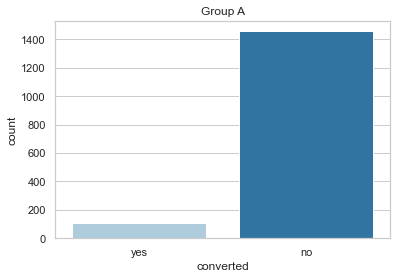

In [40]:
plt.title('Group A')
sns.countplot(data=df_act.query('grp=="A"'), 
              x="converted", 
              order=['yes', 'no'], 
              palette='Paired');
df_act.query('grp=="A"').converted.value_counts(normalize=True).mul(100).round(2)

no     93.74
yes     6.26
Name: converted, dtype: float64

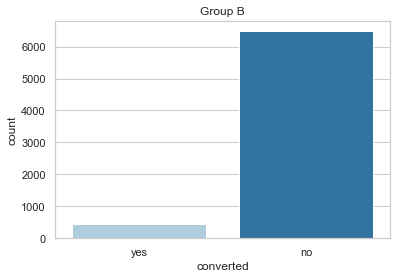

In [41]:
plt.title('Group B')
sns.countplot(data=df_act.query('grp=="B"'), x="converted", order=['yes', 'no'], palette='Paired');
df_act.query('grp=="B"').converted.value_counts(normalize=True).mul(100).round(2)

Видим, что конверсии тестовой и контрольной выборок близки друг к другу: 6.84% в контрольной и 6.26% в тестовой.  
Итак, статистически значимая разница конверсии в покупку не найдена. Возможно, это произошло из-за недостаточной мощности теста, на которую повлияло в том числе неравное распределение клиентов в тестовую и контрольную группы.

Теперь сравним ARPPU в двух группах. Для начала подготовим таблицу, оставим только строки с совершенными платежами.

In [42]:
df_act_pay = df_act.query('rev>0').copy()
df_act_pay.head()

,id,grp,active,rev,converted
1,1627,A,1.0,990.0,yes
39,3185,B,1.0,690.0,yes
121,25973,B,1.0,690.0,yes
125,26280,B,1.0,690.0,yes
220,100300,B,1.0,990.0,yes


In [43]:
# посморим, сохраняется ли распределение групп
df_act_pay.grp.value_counts(normalize=True).mul(100).round(2)

B    80.19
A    19.81
Name: grp, dtype: float64

Для выбора статистического критерия оценки метрики необходимо изучить распределения сумм платежей внутри групп. Сперва визуализируем это с помощью графиков, затем проверим с помощью критерия Шапиро-Уилка, являются ли распределения нормальными.

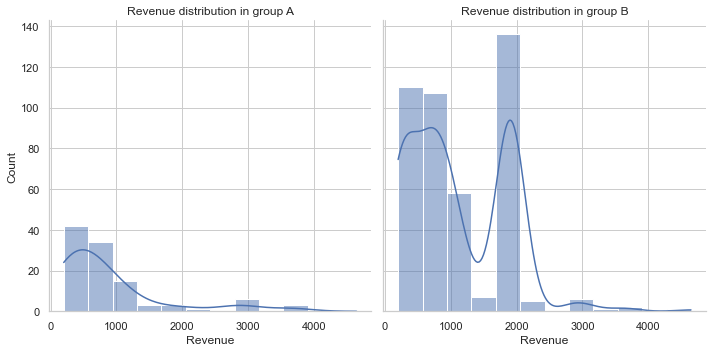

In [44]:
ax = sns.displot(data=df_act_pay, x="rev", col="grp", kde=True, palette='Paired')
ax.set_axis_labels("Revenue")
ax.set_titles("Revenue distribution in group {col_name}");

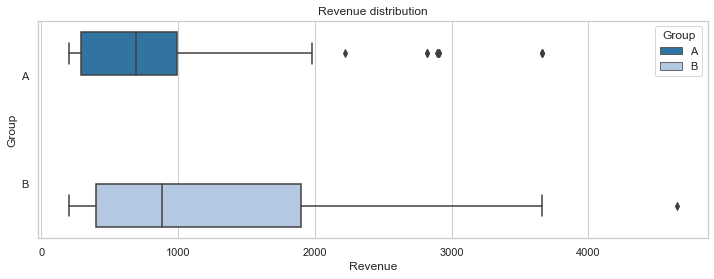

In [45]:
# посмотрим на наличие выбросов
plt.figure(figsize=(12,4))
ax = sns.boxplot(data=df_act_pay, hue='grp', x='rev', y='grp', orient="h", palette='tab20')
ax.set_xlabel('Revenue')
ax.set_ylabel('Group')
plt.legend(title="Group")
plt.title('Revenue distribution');

In [46]:
shapiro(df_act_pay.query('grp=="A"').rev)

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)

In [47]:
shapiro(df_act_pay.query('grp=="B"').rev)

ShapiroResult(statistic=0.867313027381897, pvalue=9.542798088039443e-19)

На графиках отчетливо видим, что данные далеки от нормального распределения.  
Проверка критерием Шапиро-Уилка это подтверждает. Его нулевая гипотеза состоит в том, что выборка распределена нормально. Т.к. p-value < 0.05, то нулевую гипотезу мы отклоняем.  

С помощью критерия Манна-Уитни, который не чувствителен к ненормальности распределения и выбросам, проверим гипотезу о том, что тестовая и контрольная выборки принадлежат одной генеральной совокупности, то есть распределения трат покупателей в выборках одинаковы.

In [48]:
mannwhitneyu(df_act_pay.query('grp=="A"').rev, df_act_pay.query('grp=="B"').rev)

MannwhitneyuResult(statistic=17850.0, pvalue=0.00010509845166809122)

Получившееся значение p-value меньше 0.05, а это значит, что нулевую гипотезу мы отклоняем. Различия в выборках есть. 
Теперь применим Bootstrap, используя при этом в качестве меры центральной тенденции среднее (ARPPU), что наглядно продемонстрирует нам статистическую значимость различия интересующей нас метрики ARPPU на выборках.

In [49]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

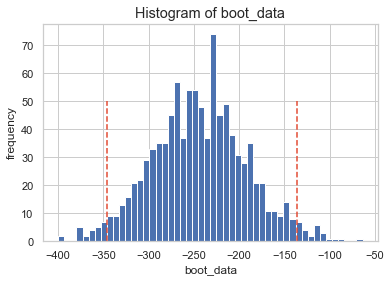

In [50]:
booted_data = get_bootstrap(df_act_pay.query('grp=="A"').rev, 
                            df_act_pay.query('grp=="B"').rev)

In [51]:
booted_data["p_value"]

2.9103216775863366e-06

In [52]:
# пределы доверительного интервала
booted_data["quants"]

,0
0.025,-346.056705
0.975,-136.435978


In [53]:
# посчитаем ARPPU контрольной группы 
df_act_pay.query('grp=="A"').rev.mean()

860.7102803738318

In [54]:
# посчитаем ARPPU тестовой группы
df_act_pay.query('grp=="B"').rev.mean()

1106.997698845266

Доверительный интервал в bootstrap-тесте не содержит ноль, а p-value<0.05. Таким образом, ARPPU тестовой выборки статистически значимо отличается от ARPPU контрольной выборки. ARPPU группы с новой механикой оплаты услуг на сайте на 246 больше, чем у группы с базовой механикой оплаты услуг.

Таким образом, сравнив с помощью статистических тестов метрики конверсии активных пользователей в покупку и ARPPU, мы приходим в выводу об успешном тестировании новой механики оплаты на платформе. С учетом имеющихся данных, можно сделать вывод что нововведение принесло положительные изменения в течение теста и стоит внедрить его на постоянной основе.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём **очень усердным** учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

2.1.2 Задача

Дана таблица peas:

| Название атрибута | Тип атрибута | Смысловое значение |
| :- | -: | -: |
| st_id | int | ID ученика |
| timest | timestamp | Время решения карточки |
| correct | bool | Правильно ли решена горошина? |
| subject | text | Дисциплина, в которой находится горошина |


Необходимо написать оптимальный запрос, который даст информацию о количестве **очень усердных** студентов за март 2020 года.

NB! Под **усердным** студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [ ]:
# Использован синтаксис PostgreSQL. 
# Для начала фильтруем данные по нужной дате и правильному решению "горошины".
# Далее для нахождения очень усердных учеников используется оконная функция, 
# которая "делит" данные по студентам и сортирует их по времени решения. 
# Из отметки времени со смещением в конец "рамки" в 20 горошин 
# (т.е. смещение на 19 строк) вычитается время текущей строки.
# Разница берется в минутах. Далее отсортировываем строки, где эта разница не более 60 минут. 
# Считаем количество очень усердных студентов.

"""
select count(*)
from
    (select st_id
    from
        (select st_id, 
                timest, 
                extract(epoch from (LEAD(timest, 19) OVER (PARTITION BY st_id ORDER BY timest) - timest))/60 as df
        from peas
        where date_trunc('month', timest) = '2020-03-01 00:00:00' and correct=1) as w
    where df<=60
    group by st_id) as st
"""

In [55]:
# т.к. у меня нет возможности подключиться через jupyter notebook к postgreSQL на учебной платформе redash, 
# то я выгрузила итоговую таблицу запроса, считаем ее
query_1 = pd.read_csv('New_Query_1.csv')
query_1

,count
0,0


По нашим данным в марте 2020 года не было ни одного очень успешного студента.

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

| Название атрибута |	Тип атрибута | Смысловое значение |
| :- | -: | -: |
| st_id	| int |	ID ученика |
| test_grp	| text |	Метка ученика в данном эксперименте |

и checks:

| Название атрибута |	Тип атрибута |	Смысловое значение |
| :- | -: | -: |
| st_id |	int |	ID ученика |
| sale_time |	timestamp	| Время покупки |
| money |	int |	Цена, по которой приобрели данный курс |
| subject	| text | Дисциплина, на которую приобрели полный доступ |


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [ ]:
# Кого принять за активных пользователей для расчетов ARPAU и CR активного пользователя в покупку? 
# Тк. у нас есть информация по решению пользователями горошин и нет информации по просто посещению платформы, то
# объединим данные тех, кто что-то решал и тех, кто оплачивал (т.к. они как минимум заходили на платформу), 
# и примем это количество за активных пользователей. И конечно берем пересечение с таблицей, 
# содержащей отметки о принадлежности к группе, тк нас интересуют только те пользователи, которые включены в эксперимент.

In [ ]:
# При расчете CR пользователя из активности по математике в покупку курса по математике важно принять во внимание 
# не только совпадение полей subject, но и временные отметки. То есть timest из таблицы peas должна быть раньше, чем
# sale_time из таблицы checks (сначала пользователь решал, а потом купил).
# Также задача состоит в том, чтобы найти конверсию из активности по математике в покупку курса, поэтому не считаю нужным 
# ставить ограничение в данных на 30 горошин (то есть в расчет принимать только тех сутдентов, которые были "вынуждены" 
# купить курс после закончившегося триала), не будем отсекать тех, кто попробовал, решив меньше 30 горошин, 
# и уже убедился в своем желании оплатить курс.

In [ ]:
"""""
with 
get_ARPU_CR(test_grp, ARPU, CR)
as (select 
        test_grp, 
        sum(money)/count(distinct s.st_id) as ARPU,
        (count(distinct c.st_id)*100)/count(distinct s.st_id) as CR
    from studs s left join checks c using(st_id) 
    group by test_grp),

get_ARPAU_CR_act(test_grp, ARPAU, CR_active)
as (select 
        test_grp, 
        rev/count(distinct s.st_id),
        (count(distinct c.st_id)*100)/count(distinct s.st_id)
    from peas p full join checks c using (st_id) 
        right join studs s using(st_id)
        join (select 
                  sum(money) as rev, 
                  test_grp 
              from studs s left join checks c using(st_id) 
              group by test_grp) as t using(test_grp)
    group by test_grp, t.rev),
    
get_CR_math(test_grp, CR_math)
as (select 
        test_grp, 
        count(c.st_id)*100/count(d.st_id)
    from
        (select distinct st_id
        from (select 
                  st_id, 
                  sale_time
              from checks c
              where c.subject = 'math') as b
            join (select 
                      st_id, 
                      timest
                 from peas p
                 where p.subject = 'math') as a using(st_id)
        where timest < sale_time) as c
        full join studs s using(st_id)
        full join (select distinct st_id
                    from peas p
                    where subject = 'math') as d using(st_id)
    group by test_grp)

select 
    test_grp, 
    ARPU, 
    ARPAU, 
    CR, 
    CR_active, 
    CR_math
from get_ARPU_CR join get_ARPAU_CR_act using (test_grp) 
    join get_CR_math using(test_grp)
    
"""""

In [62]:
# т.к. у меня нет возможности подключиться через jupyter notebook к postgreSQL на учебной платформе redash, 
# то я выгрузила итоговую таблицу запроса
query_2 = pd.read_csv('New_Query_2.csv')
query_2

,test_grp,arpu,arpau,cr,cr_active,cr_math
0,control,98,98,33,33,16
1,test,208,208,75,75,50


В наших данных все участники теста являлись активными пользователями в течение экспериментального периода. Поэтому показатели ARPU и CR совпадают с показателями ARPAU и CR_active. В то же время видим, что в этих данных все показатели тестовой группы более чем в два раза выше, чем показатели контрольной группы, это хороший результат.

# Задание 3. Python
## 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [63]:
def add_info_get_metrics(path, basic_df, df_active_st, df_checks):
    
    additional_df = pd.read_csv(path)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # найдем числовой столбец в добавочном датафрейме и присвоим ему имя 'id', как в базовой таблице
    # оставшемуся столбцу присвоим имя 'grp'
    if additional_df.iloc[:, [0]].dtypes.values in numerics:
        additional_df.columns.values[0] = 'id'
        additional_df.columns.values[1] = 'grp'
    else:
        additional_df.columns.values[0] = 'grp'
        additional_df.columns.values[1] = 'id'
    
    # теперь у нас столбцы называются одинаково и конкатенация автоматически соединит соответствующие данные
    full_data = pd.concat([basic_df, additional_df], ignore_index=True)
    
    # удалим дубликаты, если они появились
    full_data.drop_duplicates(inplace=True)
    
    # проверим, нет ли таких id, которые попали в обе группы эксперимента
    if full_data.id.nunique() != full_data.shape[0]:
         raise ValueError('Ошибка. Есть id, попавшее в обе группы эксперимента.')
    
    # соберем все таблицы в одну
    full_data = full_data.merge(df_active_st, how='left', right_on='student_id', left_on='id')\
                        .drop(columns='student_id')
    full_data = full_data.merge(df_checks, how='left', left_on='id', right_on='student_id')\
                        .drop(columns='student_id')

    # исправим показатель активности в таблице у тех пользователей, которые совершили покупку в дни эксперимента
    full_data.loc[full_data.rev.notna(), 'active'] = 1
    
    # оставим для анализа только "активных" пользователей (и тех, кого мы добавили к "активным" на прошлом шаге)
    df_act = full_data.query('active==1').copy()
    
    # заполним отсутствующие суммы покупок нулями
    df_act.rev.fillna(0, inplace=True)
    
    # добавим столбец, который будет содержать отметку, есть ли конверсия в покупку у пользователя
    df_act['converted'] = df_act.rev.apply(lambda x: 'no' if x == 0 else 'yes')
    
    # посчитаем конверсию активных пользователей в покупку
    CR_A = df_act.query('grp=="A"').converted.value_counts(normalize=True).mul(100).round(2).values[1]
    CR_B = df_act.query('grp=="B"').converted.value_counts(normalize=True).mul(100).round(2).values[1]

    # посчитаем средний доход с платящего пользователя
    df_act_pay = df_act.query('rev>0').copy() # выделили платящих пользователей
    ARPPU_A = round(df_act_pay.query('grp=="A"').rev.mean(), 2)
    ARPPU_B = round(df_act_pay.query('grp=="B"').rev.mean(), 2)
    
    return pd.DataFrame({'group': ['A', 'B'],
                         'CR': [CR_A, CR_B],
                         'ARPPU': [ARPPU_A, ARPPU_B]})

In [64]:
def get_plot(data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Metrics {data.columns[1]} and {data.columns[2]} in control (A) and test (B) groups')

    sns.barplot(ax=axes[0], data=data, x='group', y=data.columns[1], palette='Paired')
    axes[0].set_title(data.columns[1])

    sns.barplot(ax=axes[1], data=data, x='group', y=data.columns[2], palette='Paired')
    axes[1].set_title(data.columns[2]);

In [65]:
# путь к таблице, которую необходимо подгрузить
path = 'Проект_2_group_add.csv'

In [66]:
metric_data = add_info_get_metrics(path, df_groups, df_active_st, df_checks)
metric_data

,group,CR,ARPPU
0,A,6.83,860.71
1,B,6.27,1108.82


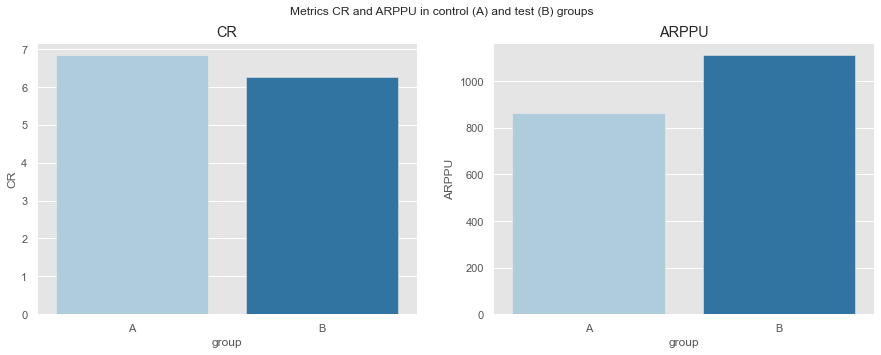

In [67]:
get_plot(metric_data)

После добавления данных метрики изменились незначительно. Больше интересна природа происходящего - почему спустя два дня к нам поступают новые данные по разметке пользователей и возникает необходимость в пересчете метрик? Вероятно, природа этого - попытка исправить ошибку разметки. Возможно, не только с логированием активных пользователей платформы случилось упущение данных. При сильных изменениях метрик, стоило бы проверить, не является ли добавление новых данных попыткой управлять результатом эксперимента.